## Algorithmic Trading: Mean Reversion 

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
import back_testing as bt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression


### Import Libraries

### Get Data

In [200]:
# Load data from CSV
csv_file_path = 'USA30IDXUSD.csv'
csv_file_path4h = 'USA30IDXUSD4h.csv'
df_ltf = pd.read_csv(csv_file_path)
df_htf = pd.read_csv(csv_file_path4h)

Format HTF Data

In [201]:
# Combine Date and Timestamp columns into a single datetime column
df_htf['date'] = pd.to_datetime(df_htf['Date'].astype(str) + ' ' + df_htf['Timestamp'].astype(str))

# Drop the original Date and Timestamp columns if no longer needed
df_htf.drop(['Date', 'Timestamp'], axis=1, inplace=True)

# Rename columns
df_htf = df_htf.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Reverse index
df_htf = df_htf.reindex(index=df_htf.index[::-1])
df_htf.reset_index(level=0, inplace=True)

# Drop the 'index' column if it's not needed
df_htf.drop('index', axis=1, inplace=True)


format LTF Data

In [202]:
# Combine Date and Timestamp columns into a single datetime column
df_ltf['date'] = pd.to_datetime(df_ltf['Date'].astype(str) + ' ' + df_ltf['Timestamp'].astype(str))

# Drop the original Date and Timestamp columns if no longer needed
df_ltf.drop(['Date', 'Timestamp'], axis=1, inplace=True)

# Rename columns
df_ltf = df_ltf.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Reverse index
df_ltf = df_ltf.reindex(index=df_ltf.index[::-1])
df_ltf.reset_index(level=0, inplace=True)

# Drop the 'index' column if it's not needed
df_ltf.drop('index', axis=1, inplace=True)

In [203]:
df_ltf = df_ltf[((df_ltf['date'] >= pd.to_datetime('2024-04-01')) & (df_ltf['date'] <= pd.to_datetime('2024-08-05')))]
df_htf = df_htf[((df_htf['date'] >= pd.to_datetime('2024-06-01')) & (df_htf['date'] <= pd.to_datetime('2024-08-07')))]

### Calculate ma

In [204]:
#Short moving averages (5-20 periods) are best suited for short-term trends and trading
df_ltf['ma_200'] = df_ltf['close'].rolling(200).mean()
df_htf['ma_100'] = df_htf['close'].rolling(100).mean()

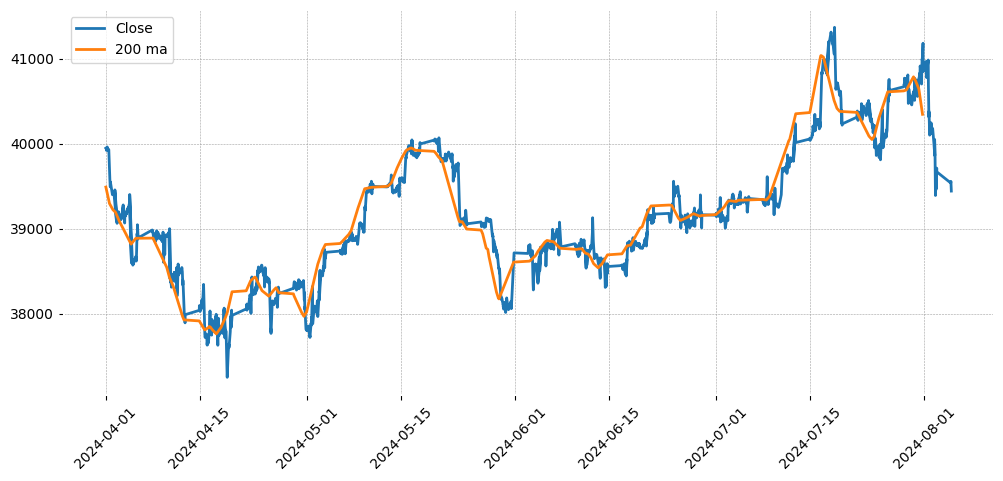

In [205]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df_ltf['date'], df_ltf['close'], label = 'Close')
plt.plot(df_ltf['date'], df_ltf['ma_200'], label = '200 ma')

plt.legend()
plt.show()

Calculate the Angle of the Linear regression 

In [210]:

def calculate_angle_and_regression(df, window=10, last_n=2, smoothing_window=5):
    angles = []
    regression_lines = np.full(len(df), np.nan)  # Initialize with NaNs

    # Apply smoothing to the 'close' values
    df['smoothed_close'] = df['close'].rolling(window=smoothing_window).mean().fillna(df['close'])
    
    for i in range(len(df) - window + 1):
        # Select 'window' data points
        subset = df.iloc[i:i + window]
        
        # Prepare data for linear regression
        X = np.arange(window).reshape(-1, 1)  # Time steps (0, 1, 2, ..., window-1)
        y = subset['smoothed_close'].values  # Smoothed closing price values

        # Fit linear regression model over the full window
        model = LinearRegression().fit(X, y)
        regression_line = model.predict(X)
        regression_lines[i:i + window] = regression_line

        # Calculate angle based on the last 'last_n' data points
        subset_last_n = subset.tail(last_n)
        X_last_n = np.arange(last_n).reshape(-1, 1)  # Time steps for last 'last_n' points
        y_last_n = subset_last_n['smoothed_close'].values  # Smoothed closing price values for last 'last_n' points

        model_last_n = LinearRegression().fit(X_last_n, y_last_n)
        slope_last_n = model_last_n.coef_[0]  # Slope of the regression line for last 'last_n' points

        # Print values for debugging
        print(f"Window {i}-{i+window-1}")
        print(f"X values: {X.flatten()}")
        print(f"Y values: {y}")
        print(f"Regression line: {regression_line}")
        print(f"Slope: {slope_last_n}")

        # Calculate angle in degrees
        angle_rad = np.arctan(slope_last_n)
        angle_deg = np.degrees(angle_rad)
        print("Angle: ", angle_deg)
        angles.append(angle_deg)
    
    # Add NaN for the first few rows that don't have enough data
    angles = [np.nan] * (window - 1) + angles
    return angles, regression_lines

In [ ]:
# Calculate angle and regression
df_htf['angle'], df_htf['regression'] = calculate_angle_and_regression(df_htf)

# Plot for validation
plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)

# Plotting the close price and linear regression line
plt.plot(df_htf['date'], df_htf['close'], label='Close')
plt.plot(df_htf['date'], df_htf['regression'], label='Linear Regression')

# Fill background based on angle
for i in range(len(df_htf) - 1):
    angle = df_htf['angle'].iloc[i]
    if angle > 5:
        plt.axvspan(df_htf['date'].iloc[i], df_htf['date'].iloc[i + 1], color='lightgreen', alpha=0.5)  # Bullish: Light Green
    elif angle < -5:
        plt.axvspan(df_htf['date'].iloc[i], df_htf['date'].iloc[i + 1], color='lightcoral', alpha=0.5)  # Bearish: Light Red
    else:
        plt.axvspan(df_htf['date'].iloc[i], df_htf['date'].iloc[i + 1], color='darkgrey', alpha=0.5)  # Ranging: Dark Grey

# Annotate the angle values
for i in range(0, len(df_htf), len(df_htf) // 10):  # Adjust the interval as needed
    plt.annotate(f'{df_htf["angle"].iloc[i]:.2f}', 
                 (df_htf['date'].iloc[i], df_htf['close'].iloc[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 fontsize=8, 
                 color='black')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price and Linear Regression with Angle Annotations')
plt.legend()
plt.show()

### Calculate Bollinger Bands

In [67]:
period = 50

#Calculate 20-ma and std dev
df_ltf['ma_20'] = df_ltf['close'].rolling(period).mean()
df_ltf['std'] = df_ltf['close'].rolling(period).std()

#Calculate bollinger bands using std dev
df_ltf['upper_bollinger'] = df_ltf['ma_20'] + (2 * df_ltf['std'])
df_ltf['lower_bollinger'] = df_ltf['ma_20'] - (2 * df_ltf['std'])

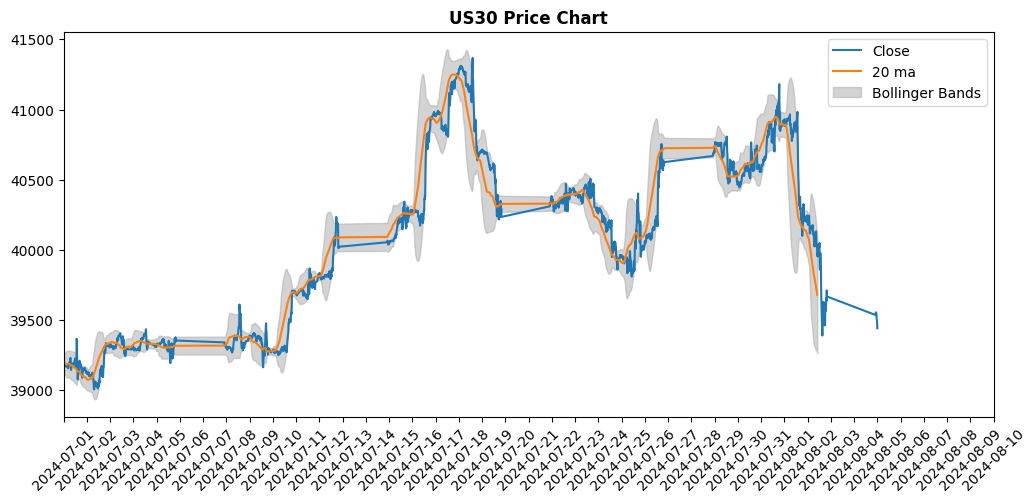

In [69]:
# Define the date range for zooming
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2024-08-10')

# Filter the DataFrame to include only data within the specified date range
filtered_df = df_ltf[(df_ltf['date'] >= start_date) & (df_ltf['date'] <= end_date)]

# Plot for validation
plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)

# Plot Close prices within the filtered date range
plt.plot(filtered_df['date'], filtered_df['close'], label='Close')

# Plot 20-period moving average within the filtered date range
if 'ma_20' in filtered_df.columns:
    plt.plot(filtered_df['date'], filtered_df['ma_20'], label='20 ma')

# Fill Bollinger Bands within the filtered date range
plt.fill_between(filtered_df['date'], filtered_df['upper_bollinger'], filtered_df['lower_bollinger'], label='Bollinger Bands', color='darkgrey', alpha=0.5)

# Add title and legend
plt.title('US30 Price Chart', fontweight="bold")
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set x-axis limits to the filtered date range
plt.xlim(start_date, end_date)

# Show the plot
plt.show()

### Calculate RSI

In [32]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [33]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [34]:
period = 13

#Calculate price delta
df_ltf['delta'] = df_ltf['close'].diff()

#Classify delta into gain & loss
df_ltf['gain'] = df_ltf['delta'].apply(lambda x:gain(x))
df_ltf['loss'] = df_ltf['delta'].apply(lambda x:loss(x))

#Calculate ema 
df_ltf['ema_gain'] = df_ltf['gain'].ewm(period).mean()
df_ltf['ema_loss'] = df_ltf['loss'].ewm(period).mean()

#Calculate RSI
df_ltf['rs'] = df_ltf['ema_gain']/df_ltf['ema_loss']
df_ltf['rsi'] = df_ltf['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

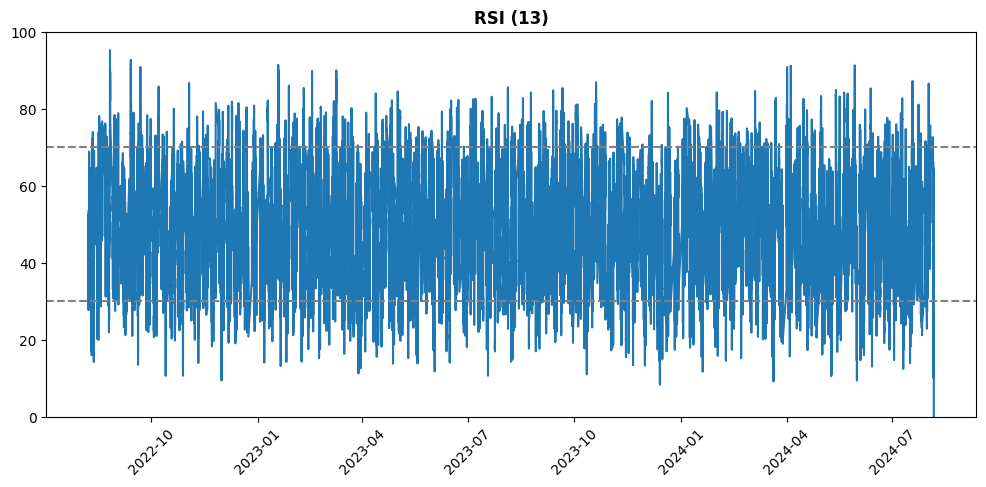

In [36]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df_ltf['date']

plt.plot(x_axis, df_ltf['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (13)', fontweight="bold")
plt.ylim([0, 100])

### Implementing buy/sell

#### Rules:
    1. Buy when 13-period RSI below 30 (buy next day) & Price below lower bollinger band
    2. Sell when 10-period RSI above 70 (sell next day) & Price above upper bollinger band

In [75]:
#buy signal
df_ltf['signal'] = np.where(
    (df_ltf['rsi'] < 30) &
    (df_ltf['close'] < df_ltf['lower_bollinger']), 1, np.nan)

#sell signal
df_ltf['signal'] = np.where(
    (df_ltf['rsi'] > 70) & 
    (df_ltf['close'] > df_ltf['upper_bollinger']), -1, df_ltf['signal'])

#buy/sell next trading day
df_ltf['signal'] = df_ltf['signal'].shift()
df_ltf['signal'] = df_ltf['signal'].fillna(0)

### Backtesting Strategy

In [76]:
bt.backtest_dataframe(df_ltf)

Buying at 40660.215 on 2024-07-31 05:00:00
Selling at 40583.251 on 2024-07-29 19:15:00
Buying at 40600.739 on 2024-07-26 19:45:00
Selling at 40329.739 on 2024-07-25 16:45:00
Buying at 40295.205 on 2024-07-19 19:45:00
Selling at 40598.797 on 2024-07-19 12:30:00
Buying at 40817.651 on 2024-07-17 13:00:00
Selling at 40190.799 on 2024-07-12 19:00:00
Buying at 39850.239 on 2024-07-12 13:45:00
Selling at 39414.203 on 2024-07-09 17:30:00
Buying at 39189.039 on 2024-07-09 13:45:00
Selling at 39544.775 on 2024-07-08 14:45:00
Buying at 39175.239 on 2024-07-02 17:30:00
Selling at 39366.215 on 2024-07-01 13:30:00
Buying at 39030.751 on 2024-06-28 19:15:00
Selling at 39396.799 on 2024-06-28 14:30:00
Buying at 39129.263 on 2024-06-28 00:45:00
Selling at 39128.863 on 2024-06-26 19:45:00
Buying at 39065.251 on 2024-06-25 16:15:00
Selling at 39281.239 on 2024-06-25 14:15:00
Buying at 39256.599 on 2024-06-24 13:15:00
Selling at 38847.751 on 2024-06-18 22:45:00
Buying at 38795.787 on 2024-06-18 18:45:00


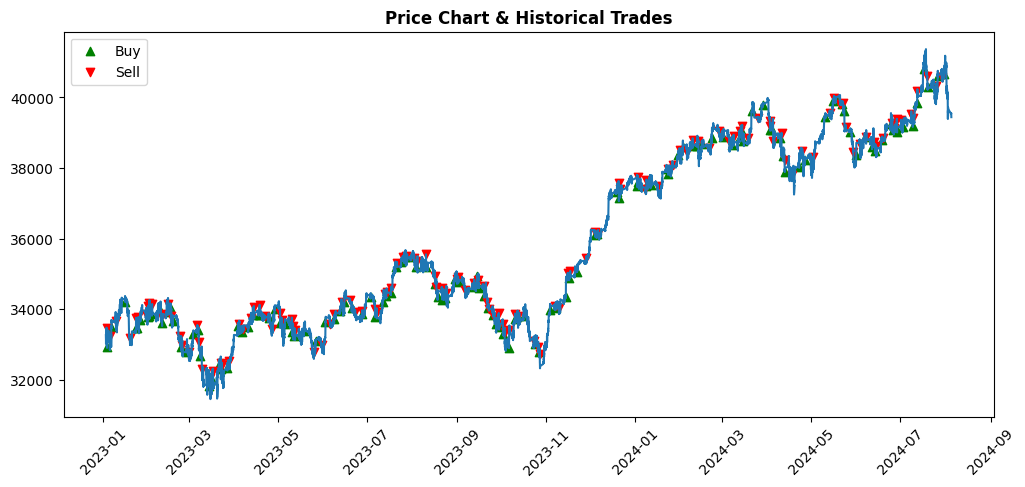

In [77]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df_ltf['close'])
plt.scatter(df_ltf[(df_ltf['signal'] == 1)]['buy_date'], df_ltf[(df_ltf['signal'] == 1)]['close'], label = 'Buy', marker='^', c='g')
plt.scatter(df_ltf[(df_ltf['signal'] == -1)]['sell_date'], df_ltf[(df_ltf['signal'] == -1)]['close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()